In [15]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_modalities = 4  # Number of modalities to align
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_temperature = 10.0
initial_relative_bias = 0.0
bias_is_trainable = True

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_modalities={n_modalities}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

# Initialize vectors for each modality
modality_vectors = []
for _ in range(n_modalities):
    U_init, _ = generate_class_vectors(n_classes, dim, device_str)
    modality_vectors.append(nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True)))

# Initialize loss function
criterion = SigLIPLoss(
    temperature=initial_temperature,
    relative_bias=initial_relative_bias,
    trainable_bias=bias_is_trainable
).to(device_str)

# Setup optimizer
params = [{'params': vectors, 'lr': 1e-2} for vectors in modality_vectors]
params.append({'params': criterion.parameters(), 'lr': 1e-2})
optimizer = torch.optim.Adam(params)

# Training loop
relative_bias_losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Calculate pairwise losses between all modalities
    total_loss = 0
    for i in range(n_modalities):
        for j in range(i+1, n_modalities):
            loss = criterion(modality_vectors[i], modality_vectors[j])
            total_loss += loss
    
    total_loss = total_loss / (n_modalities * (n_modalities - 1) / 2)  # Average over pairs
    total_loss.backward()
    optimizer.step()
    
    # Re-project vectors back onto unit sphere
    with torch.no_grad():
        for vectors in modality_vectors:
            vectors.data = vectors.data / vectors.data.norm(dim=1, keepdim=True)
    
    relative_bias_losses.append(total_loss.item())
    
    if (epoch + 1) % 100 == 0:
        tb = criterion.get_temperature()
        rb = criterion.get_bias()
        print(f"[{epoch+1}/{n_epochs}]  loss={total_loss:.4f}  T={tb:.4f}  rb={rb:.4f}")

print("\n--- Training Complete ---")
print(f"Final Loss: {relative_bias_losses[-1]:.4f}")
print(f"Final Temperature: {criterion.get_temperature():.4f}")
print(f"Final Bias Value: {criterion.get_bias():.4f}")

# Store final vectors
final_vectors = [vectors.detach() for vectors in modality_vectors]

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_modalities=4, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0.0, trainable_bias=True
[100/10000]  loss=0.0415  T=8.1974  rb=0.3732
[200/10000]  loss=0.0257  T=9.4324  rb=0.4050
[300/10000]  loss=0.0168  T=11.3242  rb=0.4440
[400/10000]  loss=0.0102  T=13.5812  rb=0.4813
[500/10000]  loss=0.0059  T=15.9475  rb=0.5131
[600/10000]  loss=0.0035  T=18.1746  rb=0.5381
[700/10000]  loss=0.0022  T=20.1512  rb=0.5573
[800/10000]  loss=0.0014  T=21.8717  rb=0.5722
[900/10000]  loss=0.0010  T=23.3704  rb=0.5841
[1000/10000]  loss=0.0007  T=24.6869  rb=0.5937
[1100/10000]  loss=0.0005  T=25.8557  rb=0.6018
[1200/10000]  loss=0.0004  T=26.9042  rb=0.6086
[1300/10000]  loss=0.0003  T=27.8543  rb=0.6145
[1400/10000]  loss=0.0003  T=28.7228  rb=0.6197
[1500/10000]  loss=0.0002  T=29.5231  rb=0.6243
[1600/10000]  loss=0.0002  T=30.2657  rb=0.6284
[1700/10000]  loss=0.0001  T=30.9591  rb=0.6322
[1800/10000]  loss=0.0001  T

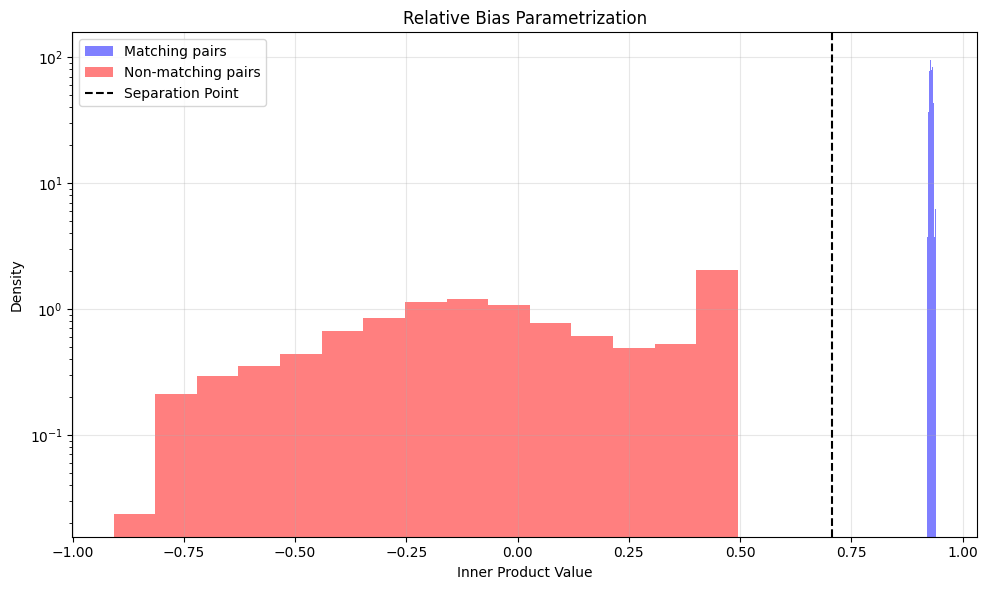

In [19]:
# Calculate all pairwise inner products between modalities
plt.figure(figsize=(10, 6))

# Collect all matching and non-matching pairs
all_matching_pairs = []
all_non_matching_pairs = []

for i in range(n_modalities):
    for j in range(i+1, n_modalities):
        inner_products = torch.matmul(final_vectors[i], final_vectors[j].t())
        
        # Get matching pairs (diagonal elements)
        matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        all_matching_pairs.extend(matching_pairs)
        
        # Get non-matching pairs (off-diagonal elements)
        mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
        non_matching_pairs = inner_products[mask].detach().cpu().numpy()
        all_non_matching_pairs.extend(non_matching_pairs)

# Plot single histograms for all matching and non-matching pairs
plt.hist(all_matching_pairs, bins=15, alpha=0.5, 
        label='Matching pairs', color='blue', density=True, log=True)
plt.hist(all_non_matching_pairs, bins=15, alpha=0.5, 
        label='Non-matching pairs', color='red', density=True, log=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(all_matching_pairs)
max_non_matching = np.max(all_non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='black', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value')
plt.ylabel('Density')
plt.title('Relative Bias Parametrization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [27]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_modalities = 4  # Number of modalities to align
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_temperature = 10.0
initial_bias = -10.0
bias_is_trainable = True

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_modalities={n_modalities}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

# Initialize vectors for each modality
modality_vectors = []
for _ in range(n_modalities):
    U_init, _ = generate_class_vectors(n_classes, dim, device_str)
    modality_vectors.append(nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True)))

# Initialize loss function
criterion = SigLIPLoss(
    temperature=initial_temperature,
    bias=initial_bias,
    trainable_bias=bias_is_trainable,
    relative_bias_parameterization=False
).to(device_str)

# Setup optimizer
params = [{'params': vectors, 'lr': 1e-2} for vectors in modality_vectors]
params.append({'params': criterion.parameters(), 'lr': 1e-2})
optimizer = torch.optim.Adam(params)

# Training loop
bias_losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Calculate pairwise losses between all modalities
    total_loss = 0
    for i in range(n_modalities):
        for j in range(i+1, n_modalities):
            loss = criterion(modality_vectors[i], modality_vectors[j])
            total_loss += loss
    
    total_loss = total_loss / (n_modalities * (n_modalities - 1) / 2)  # Average over pairs
    total_loss.backward()
    optimizer.step()
    
    # Re-project vectors back onto unit sphere
    with torch.no_grad():
        for vectors in modality_vectors:
            vectors.data = vectors.data / vectors.data.norm(dim=1, keepdim=True)
    
    bias_losses.append(total_loss.item())
    
    if (epoch + 1) % 100 == 0:
        tb = criterion.get_temperature()
        rb = criterion.get_bias()
        print(f"[{epoch+1}/{n_epochs}]  loss={total_loss:.4f}  T={tb:.4f}  rb={rb:.4f}")

print("\n--- Training Complete ---")
print(f"Final Loss: {bias_losses[-1]:.4f}")
print(f"Final Temperature: {criterion.get_temperature():.4f}")
print(f"Final Bias Value: {criterion.get_bias():.4f}")

# Store final vectors
final_vectors = [vectors.detach() for vectors in modality_vectors]

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_modalities=4, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0.0, trainable_bias=True
[100/10000]  loss=0.1715  T=34.8768  rb=-9.1407
[200/10000]  loss=0.1177  T=39.5741  rb=-9.0894
[300/10000]  loss=0.0493  T=41.2912  rb=-9.0747
[400/10000]  loss=0.0345  T=44.0205  rb=-9.0545
[500/10000]  loss=0.0268  T=47.0563  rb=-9.0348
[600/10000]  loss=0.0212  T=50.0485  rb=-9.0177
[700/10000]  loss=0.0169  T=53.0114  rb=-9.0026
[800/10000]  loss=0.0135  T=55.9473  rb=-8.9893
[900/10000]  loss=0.0109  T=58.8340  rb=-8.9774
[1000/10000]  loss=0.0088  T=61.6460  rb=-8.9670
[1100/10000]  loss=0.0071  T=64.3654  rb=-8.9577
[1200/10000]  loss=0.0058  T=66.9816  rb=-8.9495
[1300/10000]  loss=0.0048  T=69.4893  rb=-8.9422
[1400/10000]  loss=0.0040  T=71.8880  rb=-8.9357
[1500/10000]  loss=0.0033  T=74.1803  rb=-8.9299
[1600/10000]  loss=0.0028  T=76.3708  rb=-8.9247
[1700/10000]  loss=0.0024  T=78.4653  rb=-8.9199
[1800/100

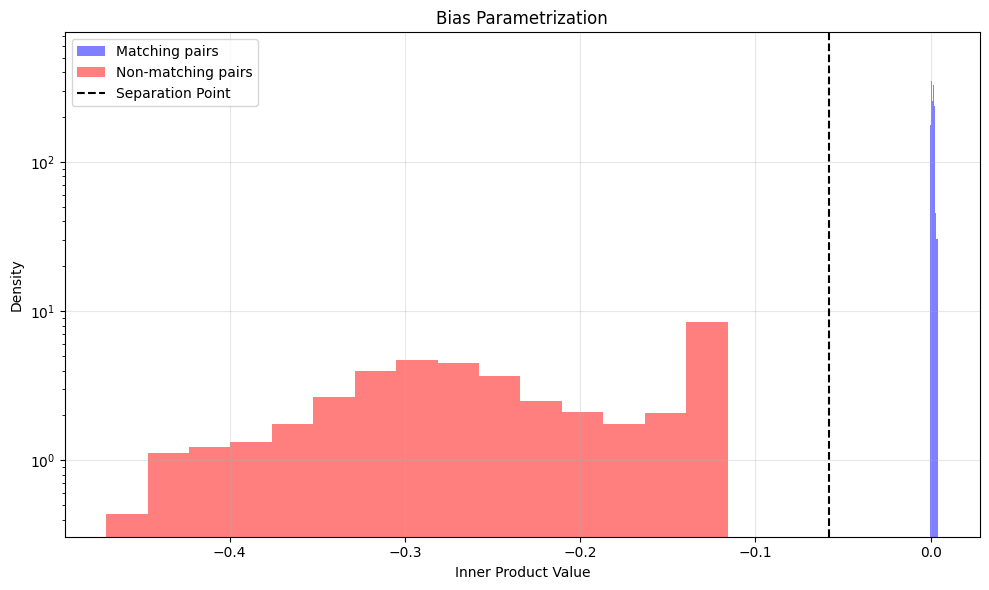

In [22]:
# Calculate all pairwise inner products between modalities
plt.figure(figsize=(10, 6))

# Collect all matching and non-matching pairs
all_matching_pairs = []
all_non_matching_pairs = []

for i in range(n_modalities):
    for j in range(i+1, n_modalities):
        inner_products = torch.matmul(final_vectors[i], final_vectors[j].t())
        
        # Get matching pairs (diagonal elements)
        matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        all_matching_pairs.extend(matching_pairs)
        
        # Get non-matching pairs (off-diagonal elements)
        mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
        non_matching_pairs = inner_products[mask].detach().cpu().numpy()
        all_non_matching_pairs.extend(non_matching_pairs)

# Plot single histograms for all matching and non-matching pairs
plt.hist(all_matching_pairs, bins=15, alpha=0.5, 
        label='Matching pairs', color='blue', density=True, log=True)
plt.hist(all_non_matching_pairs, bins=15, alpha=0.5, 
        label='Non-matching pairs', color='red', density=True, log=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(all_matching_pairs)
max_non_matching = np.max(all_non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='black', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value')
plt.ylabel('Density')
plt.title('Bias Parametrization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_modalities = 4  # Number of modalities to align
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_temperature = 10.0
initial_bias = -10.0
bias_is_trainable = False

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_modalities={n_modalities}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

# Initialize vectors for each modality
modality_vectors = []
for _ in range(n_modalities):
    U_init, _ = generate_class_vectors(n_classes, dim, device_str)
    modality_vectors.append(nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True)))

# Initialize loss function
criterion = SigLIPLoss(
    temperature=initial_temperature,
    trainable_temp=False,
    bias=initial_bias,
    trainable_bias=bias_is_trainable,
    relative_bias_parameterization=False
).to(device_str)

# Setup optimizer
params = [{'params': vectors, 'lr': 1e-2} for vectors in modality_vectors]
params.append({'params': criterion.parameters(), 'lr': 1e-2})
optimizer = torch.optim.Adam(params)

# Training loop
fixed_losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Calculate pairwise losses between all modalities
    total_loss = 0
    for i in range(n_modalities):
        for j in range(i+1, n_modalities):
            loss = criterion(modality_vectors[i], modality_vectors[j])
            total_loss += loss
    
    total_loss = total_loss / (n_modalities * (n_modalities - 1) / 2)  # Average over pairs
    total_loss.backward()
    optimizer.step()
    
    # Re-project vectors back onto unit sphere
    with torch.no_grad():
        for vectors in modality_vectors:
            vectors.data = vectors.data / vectors.data.norm(dim=1, keepdim=True)
    
    fixed_losses.append(total_loss.item())
    
    if (epoch + 1) % 100 == 0:
        tb = criterion.get_temperature()
        rb = criterion.get_bias()
        print(f"[{epoch+1}/{n_epochs}]  loss={total_loss:.4f}  T={tb:.4f}  rb={rb:.4f}")

print("\n--- Training Complete ---")
print(f"Final Loss: {fixed_losses[-1]:.4f}")
print(f"Final Temperature: {criterion.get_temperature():.4f}")
print(f"Final Bias Value: {criterion.get_bias():.4f}")

# Store final vectors
final_vectors = [vectors.detach() for vectors in modality_vectors]

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_modalities=4, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0.0, trainable_bias=False
[100/10000]  loss=6.6054  T=10.0000  rb=-10.0000
[200/10000]  loss=6.6017  T=10.0000  rb=-10.0000
[300/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[400/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[500/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[600/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[700/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[800/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[900/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1000/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1100/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1200/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1300/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1400/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1500/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1600/10000]  loss=6.6013  T=10.0000  rb=-10.0000
[1700/10000]  loss=6.6013  T=10.0000  rb=

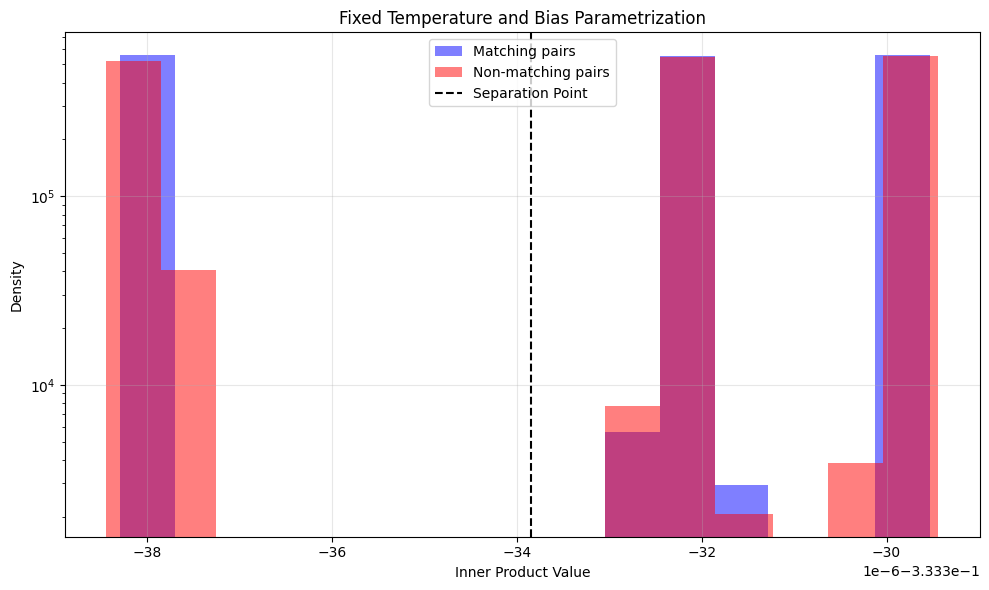

In [24]:
# Calculate all pairwise inner products between modalities
plt.figure(figsize=(10, 6))

# Collect all matching and non-matching pairs
all_matching_pairs = []
all_non_matching_pairs = []

for i in range(n_modalities):
    for j in range(i+1, n_modalities):
        inner_products = torch.matmul(final_vectors[i], final_vectors[j].t())
        
        # Get matching pairs (diagonal elements)
        matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        all_matching_pairs.extend(matching_pairs)
        
        # Get non-matching pairs (off-diagonal elements)
        mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
        non_matching_pairs = inner_products[mask].detach().cpu().numpy()
        all_non_matching_pairs.extend(non_matching_pairs)

# Plot single histograms for all matching and non-matching pairs
plt.hist(all_matching_pairs, bins=15, alpha=0.5, 
        label='Matching pairs', color='blue', density=True, log=True)
plt.hist(all_non_matching_pairs, bins=15, alpha=0.5, 
        label='Non-matching pairs', color='red', density=True, log=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(all_matching_pairs)
max_non_matching = np.max(all_non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='black', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value')
plt.ylabel('Density')
plt.title('Fixed Temperature and Bias Parametrization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


→ Training with 4 modalities...
  epoch 1000/10000, loss=0.0007
  epoch 2000/10000, loss=0.0001
  epoch 3000/10000, loss=0.0000
  epoch 4000/10000, loss=0.0000
  epoch 5000/10000, loss=0.0000
  epoch 6000/10000, loss=0.0000
  epoch 7000/10000, loss=0.0000
  epoch 8000/10000, loss=0.0000
  epoch 9000/10000, loss=0.0000
  epoch 10000/10000, loss=0.0000
→ Training with 6 modalities...
  epoch 1000/10000, loss=0.0015
  epoch 2000/10000, loss=0.0001
  epoch 3000/10000, loss=0.0000
  epoch 4000/10000, loss=0.0000
  epoch 5000/10000, loss=0.0000
  epoch 6000/10000, loss=0.0000
  epoch 7000/10000, loss=0.0000
  epoch 8000/10000, loss=0.0000
  epoch 9000/10000, loss=0.0000
  epoch 10000/10000, loss=0.0000
→ Training with 8 modalities...
  epoch 1000/10000, loss=0.0003
  epoch 2000/10000, loss=0.0001
  epoch 3000/10000, loss=0.0000
  epoch 4000/10000, loss=0.0000
  epoch 5000/10000, loss=0.0000
  epoch 6000/10000, loss=0.0000
  epoch 7000/10000, loss=0.0000
  epoch 8000/10000, loss=0.0000
  epoc

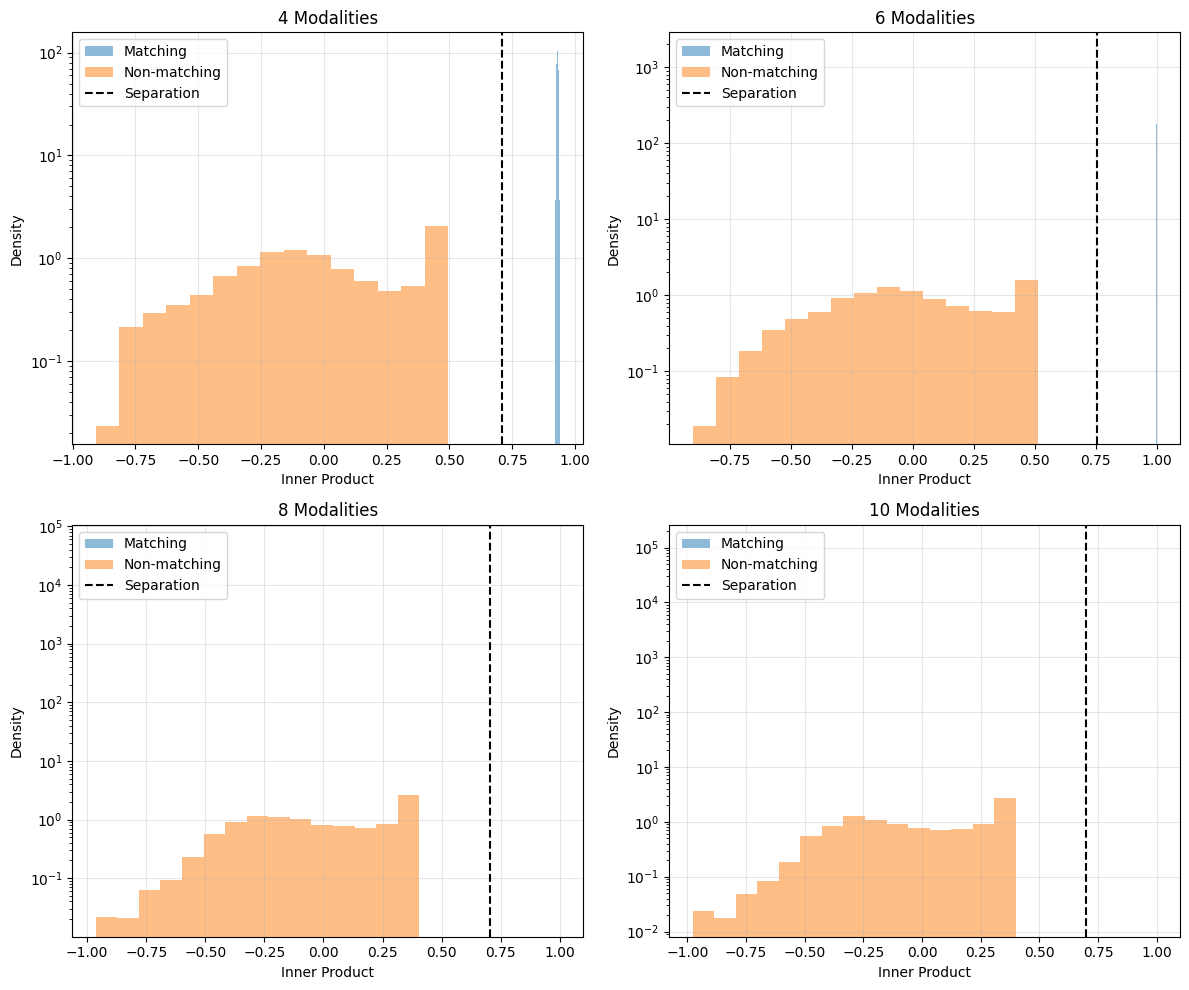

In [25]:
# Experiment hyperparams
torch.manual_seed(50)
n_classes = 100
dim = 10
modalities_list = [4, 6, 8, 10]
n_epochs = int(1e4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

initial_temperature = 10.0
initial_relative_bias = 0.0
bias_is_trainable = True
lr = 1e-2

# Container for final vectors
all_results = {}

for n_modalities in modalities_list:
    print(f"→ Training with {n_modalities} modalities...")
    
    # Initialize modality vectors
    modality_vectors = []
    for _ in range(n_modalities):
        U_init, _ = generate_class_vectors(n_classes, dim, device)
        vecs = nn.Parameter(U_init / U_init.norm(dim=1, keepdim=True))
        modality_vectors.append(vecs)
    
    # SigLIP loss
    criterion = SigLIPLoss(
        temperature=initial_temperature,
        relative_bias=initial_relative_bias,
        trainable_bias=bias_is_trainable
    ).to(device)
    
    # Optimizer over both vectors and loss parameters
    optim_params = [{'params': mv, 'lr': lr} for mv in modality_vectors]
    optim_params.append({'params': criterion.parameters(), 'lr': lr})
    optimizer = torch.optim.Adam(optim_params)
    
    # Training loop
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        total_loss = 0
        for i in range(n_modalities):
            for j in range(i+1, n_modalities):
                total_loss += criterion(modality_vectors[i], modality_vectors[j])
        total_loss = total_loss / (n_modalities*(n_modalities-1)/2)
        total_loss.backward()
        optimizer.step()
        
        # Re-project onto unit sphere
        with torch.no_grad():
            for mv in modality_vectors:
                mv.data.div_(mv.data.norm(dim=1, keepdim=True))
        
        if (epoch + 1) % 1000 == 0:
            print(f"  epoch {epoch+1}/{n_epochs}, loss={total_loss:.4f}")
    
    # Detach and store
    all_results[n_modalities] = [mv.detach().cpu() for mv in modality_vectors]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, n_mod in zip(axes, modalities_list):
    final_vecs = all_results[n_mod]
    matching = []
    non_matching = []
    
    for i in range(n_mod):
        for j in range(i+1, n_mod):
            ip = final_vecs[i] @ final_vecs[j].T  # inner product matrix
            diag = ip.diag().numpy()
            matching.extend(diag)
            
            mask = ~np.eye(n_classes, dtype=bool)
            non_diag = ip.numpy()[mask]
            non_matching.extend(non_diag)
    
    ax.hist(matching, bins=15, alpha=0.5, label='Matching', density=True, log=True)
    ax.hist(non_matching, bins=15, alpha=0.5, label='Non-matching', density=True, log=True)
    
    min_mat, max_non = np.min(matching), np.max(non_matching)
    sep = (min_mat + max_non) / 2
    ax.axvline(sep, color='k', linestyle='--', label='Separation')
    
    ax.set_title(f'{n_mod} Modalities')
    ax.set_xlabel('Inner Product')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

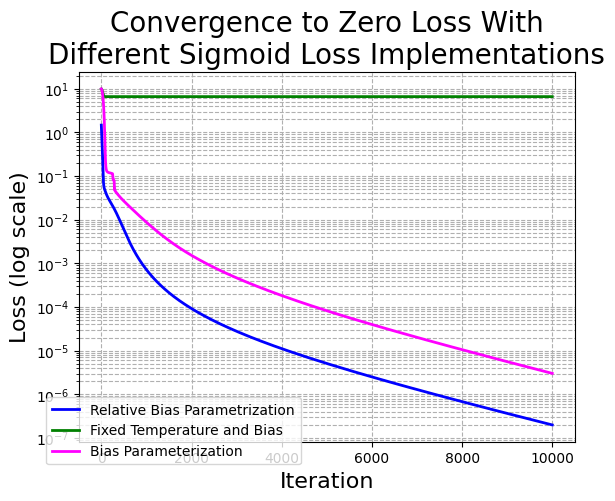

In [30]:
#plt.figure(figsize=(8, 6))
iters= np.arange(10000)
# Plot the two lines
plt.plot(iters, relative_bias_losses , label='Relative Bias Parametrization', linewidth=2,color = "blue")
plt.plot(iters, fixed_losses, label= 'Fixed Temperature and Bias', linewidth=2,color = "green")
plt.plot(iters, bias_losses, label= 'Bias Parameterization', linewidth=2,color = "magenta")

# Set log scale on y-axis (or use plt.xscale("log") for x-axis)
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Loss (log scale)', fontsize = 16)
plt.title('Convergence to Zero Loss With\nDifferent Sigmoid Loss Implementations', fontsize = 20)
plt.legend(fontsize = 10,loc='lower left', bbox_to_anchor=(-.08, -.08))
plt.grid(True, which='both', linestyle='--')

plt.savefig('logs/losscomparisonadaptervsno.png',dpi =300,  bbox_inches='tight')
# Show the plot
plt.show()